Now let's do the same, but with a different method. First read the same data and import everything we need:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataset91 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short91_f1_000.csv.gz',index_col=False)
dataset92 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short92_e2_000.csv.gz',index_col=False)
dataset93 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short93_d2_000.csv.gz',index_col=False)
dataset94 = pd.read_csv('https://raw.githubusercontent.com/kraikisto/CERN_LEP_Z_boson/main/dimuon_short94_c2_000.csv.gz',index_col=False)


This method of finding the particle relies on the fact that in the large electron-positron collider we used to exclusively create Z-particles. So now we look at the results for the amount of event (Z-bosons created) for different center-of-mass energies that the collider has been runninng on and see where it has had the most success creating Z-bosons, relative to the amount of attempts. 

Now we need to define the integrated luminosity for each event. Luminosity is defined as

$$
L = \dfrac{1}{\sigma} \dfrac{dN}{dt}
$$

meaning it is the rate of events divided by cross-section. Cross-section describes the probability of the colliding particles actually causing a reaction. Therefore integraded luminosity is just the total number of events divided by the cross-section. Because the cross-section is different for different values of center-of-mass energy (ECM) and it becomes larges as ECM gets closer to the actual mass of the particle, it makes for a good metric to find the particle. To get the cross-section, we can divide the number of datapoints we have for a value of ECM by the integrated luminosity. 

Since each center-of-mass energy (ECM) value has a different luminosity we need to find all ECM values and that can be done by using `.ECM.unique()` function on the dataset. From that we can see some values that are quite close to each other. This is because of noise in the measurement and can be fixed by setting the luminosity to all the ECM values less than 0.1 away from the exact value. Doing that we find that there are 7 different sections for ECM. Using the table given we can assing a luminosity to each datapoint in the dataset using .loc.

In [2]:
#section 1: 
lum1 = 629 #luminosity for this section
condition1 = np.abs(dataset91.ECM-88.5) < 0.1 #ECM for this section is near 88.5
dataset91.loc[condition1, "LUM"] = lum1 #set the luminosity under row "LUM"


#section 2: 
lum2 = 647
condition2 = np.abs(dataset91.ECM-89.5) < 0.1
dataset91.loc[condition2, "LUM"] = lum2


#section 3: 
lum3 = 633
condition3 = np.abs(dataset91.ECM-90.2) < 0.1
dataset91.loc[condition3 , "LUM"] = lum3


#section 4: 
lum4 = 2274
condition4 = np.abs(dataset91.ECM-91.2) < 0.1
dataset91.loc[condition4, "LUM"] = lum4


#section 5: 
lum5 = 680
condition5 = np.abs(dataset91.ECM-92) < 0.1
dataset91.loc[condition5, "LUM"] = lum5


#section 6: 
lum6 = 634
condition6 = np.abs(dataset91.ECM-93) < 0.1
dataset91.loc[condition6, "LUM"] = lum6


#section 7: 
lum7 = 492
condition7 = np.abs(dataset91.ECM-93.7) < 0.1
dataset91.loc[condition7, "LUM"] = lum7


Now let's plot the histogram.  Instead of dividing all of the ECM values by the luminosity, we can simply weight the histogram by 1/luminosity. We also set the amount of bins to match the amount of sections. 

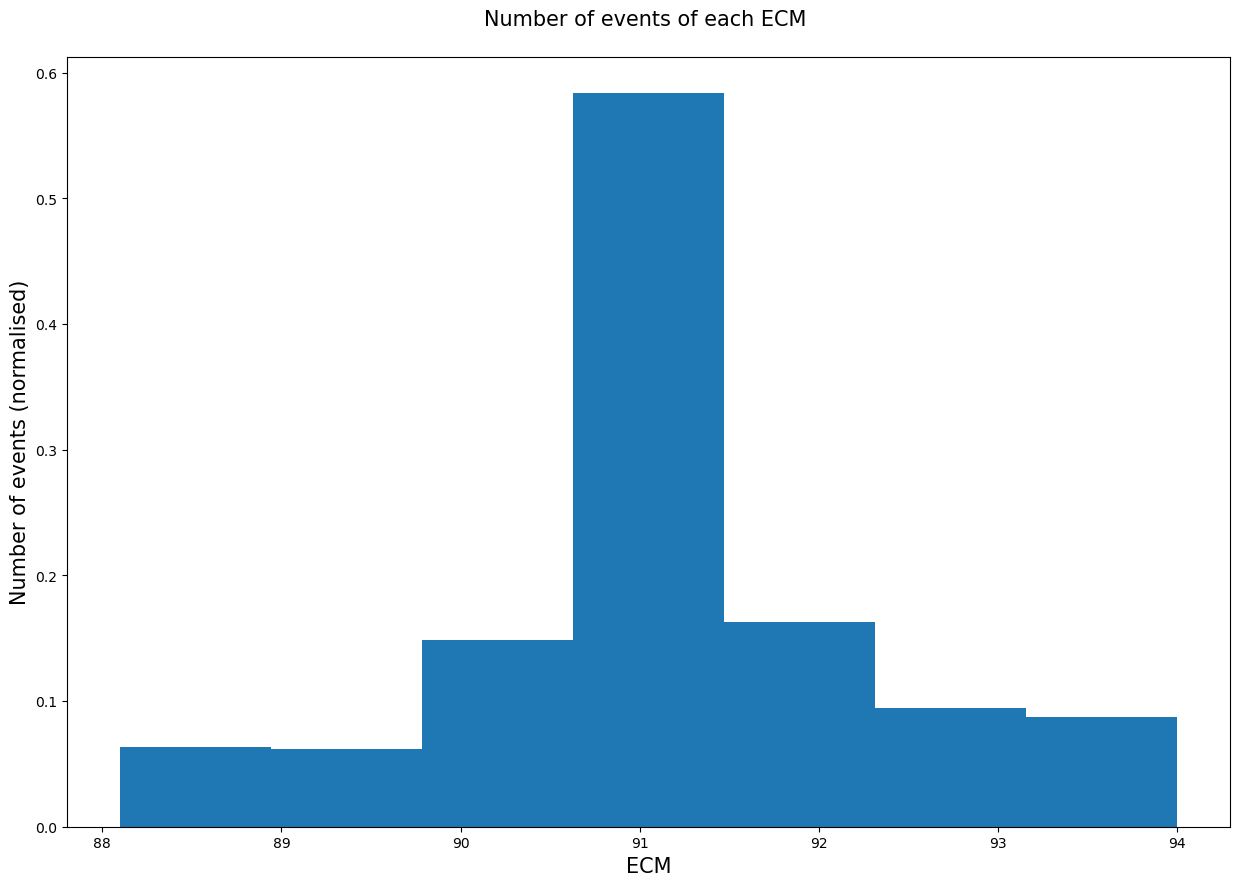

In [3]:
lowerlimit = 88.1
upperlimit = 94
bins=7


#weighted by luminosity
fig = plt.figure(figsize=(15, 10))
histogram = plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit), weights = 1/dataset91.LUM)

plt.xlabel('ECM', fontsize=15)
plt.ylabel('Number of events (normalised)', fontsize=15)
plt.title('Number of events of each ECM \n', fontsize=15) 

plt.show()

Now that we have the histogram we can start analysing it. There is a peak (often called a resonance) at around 103 GeV. This peak signifies a particle. We can actually get more from this histogram. This is done by plotting what is called a Breit-Wigner function on the histogram. Breit-Wigner distribution is of the following form:

$$
f(E) = \dfrac{k}{(E^2 - M^2)^2 + M^2 \Gamma^2} 
$$

where $k = \dfrac{2\sqrt{2}M \Gamma \gamma}{\pi\sqrt{M^2 + \gamma}}$ with $\gamma = \sqrt{M^2(M^2 + \Gamma^2)}$ which are in natural units $\hbar = c = 1$. 


Let's now create the fit just like in the previous exercise. First we define a function that matches the form of the Breit-Wigner function given earlier. As with the fitting on invariant mass values we need some initial guesses. Then we fit this function into the histogram by using `curve_fit()` from `scipy.optimize`. Let's also save the best values and covariance that the fitting gives us. 

In [4]:
from scipy.optimize import curve_fit

def breitwigner(E, gamma, M, a, b, A):
    return a*E+b+A*( (2*np.sqrt(2)*M*gamma*np.sqrt(M**2*(M**2+gamma**2)))/(np.pi*np.sqrt(M**2+np.sqrt(M**2*(M**2+gamma**2)))) )/((E**2-M**2)**2+M**2*gamma**2)


#Initial guesses:
initials = [1, 91, 1, 3, 1]


#Histogram as an object consists of 2 lists: List of the heights of the bars and the edges of the bins
#Using normal list operations we can use the histogram to get x and y coordinates:
y = histogram[0] #gives the height of each bar in a list
x = 0.5*(histogram[1][0:-1] + histogram[1][1:]) #list of midpoints of a bins

#Fits the defined Breit-Wigner function to the (x,y) points gotten from the histogram
best, covariance = curve_fit(breitwigner, x, y, p0=initials, sigma=np.sqrt(y)) #sigma is the magnitude of the uncertainty in y-data

Lastly we plot both this fitted function and the histogram into the same picture. We can also print the best values and their limits of error, which can be easily calculated from the covariances since they are the square roots of the variances. To smooth out the fit we set the step size for the function to be 0.2. 

The values and the uncertainties from the optimization:

The value of the decay width = 0.7886296756453656 +- 0.0918390179803417
The value of the maximum of the distribution = 91.07702222900207 +- 0.07029964817530505
a = 0.006106930887575333 +- 0.0030381973834410787
b = -0.4986757451901471 +- 0.2755306661490679
A = 0.6555226483809931 +- 0.07958031982158413


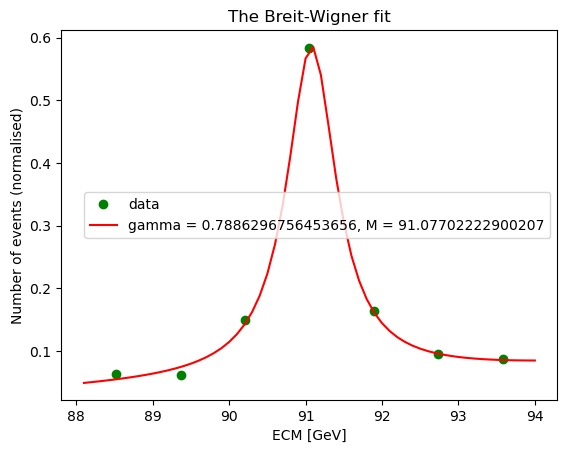

In [5]:
#Covariance is is determined using the sigma given. The diagonal elements are the variances.
error = np.sqrt(np.diag(covariance))
    
#Parameters and their errors from optimization:
print("The values and the uncertainties from the optimization:")
print("")

#format is a useful function when printing values of variables
print("The value of the decay width = {} +- {}".format(best[0], error[0])) 
print("The value of the maximum of the distribution = {} +- {}".format(best[1], error[1]))
print("a = {} +- {}".format(best[2], error[2]))
print("b = {} +- {}".format(best[3], error[3]))
print("A = {} +- {}".format(best[4], error[4]))

#For the smoother fit:
more_points = np.arange(lowerlimit,upperlimit, step=0.1)


#plot both graphs:
plt.plot(x, y, 'go', label='data')
plt.plot(more_points, breitwigner(more_points, *best), 'r-', label='gamma = {}, M = {}'.format(best[0], best[1]))
plt.xlabel('ECM [GeV]')
plt.ylabel('Number of events (normalised)')
plt.title('The Breit-Wigner fit')
plt.legend()
plt.show()

Well what do we get out of this? Well now we know the value of gamma, which is the resonance width. It is also connected to mean lifetime of the particle which the resonance correlates to. (Do the other variables mean anything?). The mean lifetime can be calculated from the formula:

$$
\Gamma = \dfrac{\hbar}{\tau}
$$

where $\hbar$ is the reduced Planck constant and $\tau$ the lifetime of the particle. 

In [6]:
print("Mean lifetime is {} in the natural units".format(1/best[0]))

Mean lifetime is 1.2680222807766675 in the natural units


An interesting comparison can be made using the cross-section values already calculated in the table. If we plot them and make a similar fit we get this figure:

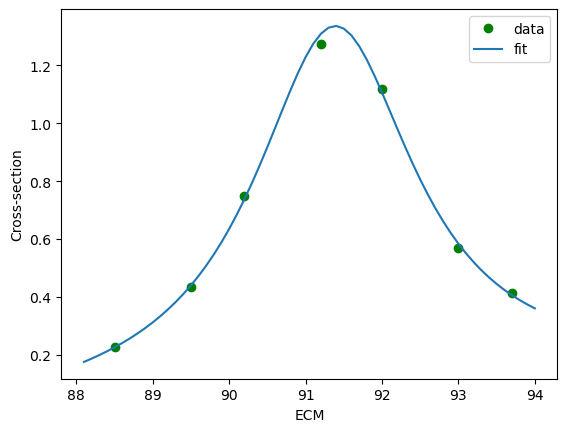

The value of the decay width = 2.56991502397947 +- 0.18085226017397044
The value of the maximum of the distribution = 91.3768860504257 +- 0.03409158736774711
a = 0.02026659907313824 +- 0.005959918369470821
b = -1.7844339528612407 +- 0.5272365882432801
A = 5.11999611081458 +- 0.4060038298724675


In [7]:
ECM = np.array([88.5, 89.5, 90.2, 91.2, 92, 93, 93.7], dtype=float) #ECM values from the table
cross_section = np.array([0.227, 0.436, 0.750, 1.275, 1.120, 0.568, 0.415], dtype=float) #cross-section values from the table

best2, covariance2 = curve_fit(breitwigner, ECM, cross_section, p0=initials, sigma=np.sqrt(y))



plt.plot(ECM, cross_section, 'go', label='data')
plt.plot(more_points, breitwigner(more_points, *best2), '-', label='fit')
plt.xlabel("ECM")
plt.ylabel("Cross-section")
plt.legend()
plt.show()


error2 = np.sqrt(np.diag(covariance2))
print("The value of the decay width = {} +- {}".format(best2[0], error2[0])) 
print("The value of the maximum of the distribution = {} +- {}".format(best2[1], error2[1]))
print("a = {} +- {}".format(best2[2], error2[2]))
print("b = {} +- {}".format(best2[3], error2[3]))
print("A = {} +- {}".format(best2[4], error2[4]))

Comparison between data and the values from the paper (values normalised to where the peak is the same height). 

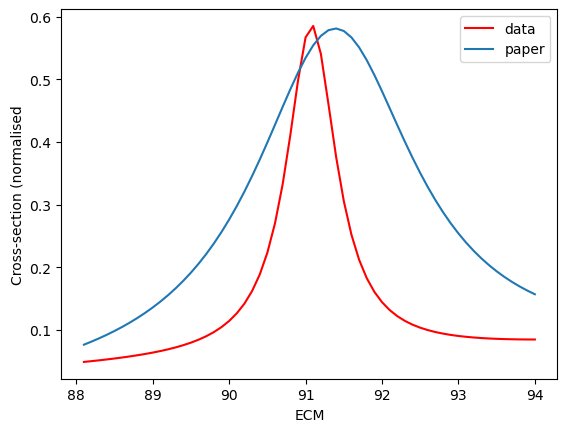

In [14]:
plt.plot(more_points, breitwigner(more_points, *best), 'r-', label='data'.format(best[0], best[1]))
plt.plot(more_points, breitwigner(more_points, *best2)/2.3, '-', label='paper')
plt.xlabel("ECM")
plt.ylabel("Cross-section (normalised")
plt.legend()
plt.show()

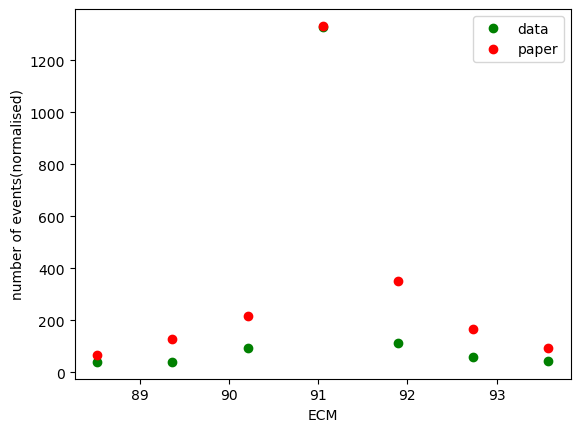

0.2623699507389162


In [31]:
histogram = plt.hist(dataset91.ECM, bins=bins, range=(lowerlimit,upperlimit))
plt.close()
y = histogram[0] #gives the height of each bar in a list
n = np.array([137, 269, 448, 2757, 725, 344, 195], dtype=float)/2.07


#Here the plots are adjusted so that the peaks are the same so that comparing is easier
plt.plot(x, y, 'go', label='data')
plt.plot(x, n, 'ro', label='paper')
plt.xlabel("ECM")
plt.ylabel("number of events(normalised)")
plt.legend()
plt.show()
print(x[4]/n[4])

Even though in the dataset, the number of values is smaller for all ECM values, when matching the peaks by dividing all values form the paper by 2.07, it is clear that the amount of missing data is not uniform. The worst one is around 92 ECM, where only 26% of the data is left, causing the big discrepency seen in the previous comparison. 